# TDEM Step off experiment

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This notebook was used to produce Figure 7 in Heagy and Oldenburg (2018). We run a top-casing time domain em experiment. One electrode is connected to the top of the casing and another is 1km away (on the surface). We then view the currents through time. 

If you encounter problems when running this notebook, please [open an issue](https://github.com/simpeg-research/heagy_2018_emcyl/issues). 

## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them. 

In [1]:
# !pip install -r ../requirements.txt

In [1]:
# core python
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
from scipy.spatial import cKDTree
import os
import tarfile
import ipywidgets
import time

# SimPEG, discretize
import discretize
from discretize import utils
from SimPEG.EM import TDEM
from SimPEG import Utils, Maps
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casingSim

%matplotlib inline

The fields file that contains all of the currents on the mesh through time is quite large (2.3 GB) and takes a while to download. To lighten this, we have provided results that have been down-sampled through time. If `use_downsampled_resuts` is True, we will use those, otherwise, we download the entire fields file. 

## model parameters

In [2]:
simDir = "TDEM_fields_response_1km"
simDir_background = "TDEM_fields_response_1km_background"

In [3]:
# conductivities
sigma_air = 1e-5
sigma_back = 1e-2
sigma_casing = sigma_back
sigma_casing = 5e6

# relative permeability of the casing
mur_casing = 1.

# casing geometry
casing_diameter = 10e-2  
casing_t = 10e-3
casing_l = 1000

# cell size in the z-direction for the mesh
csz = 2.5 

Source electrode locations. The source runs along the $\theta = 90^{\circ}$ line

In [4]:
src_a = np.r_[casing_diameter / 2., np.pi/2, 0.]
src_b = np.r_[casing_l, np.pi/2, 0.]

In [5]:
model = casingSim.model.CasingInHalfspace(
    directory = simDir, 
    casing_d = casing_diameter - casing_t,  # I use diameter to the center of the casing wall
    casing_l = casing_l,
    casing_t = casing_t, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sigma_casing,
    sigma_back = sigma_back,
    sigma_inside = sigma_back,
    src_a = src_a,
    src_b = src_b
)
model.filename = "casing.json"

Create the time-stepping for the forward simulation

In [6]:
timeSteps = [
    (1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 17)
]

model.timeSteps = timeSteps

print("The latest time is {:1.1e}s".format(model.timeSteps.sum()))
print("There are {} time-steps in the simulation, {} are unique "
      "(this controls how many matrix factorizations need to be done)".format(
          len(model.timeSteps), len(np.unique(np.diff(model.timeSteps)))
      )
)

The latest time is 2.0e-01s
There are 187 time-steps in the simulation, 7 are unique (this controls how many matrix factorizations need to be done)


Duplicate the model so that we can run a `background` model that does not include casing.

In [7]:
model.diffusion_distance(2e-1)

model_background = model.copy()
model_background.sigma_casing = model_background.sigma_back
model_background.filename = "background.json"

model_permeable = model.copy()
model_permeable.mur_casing = 100
model_permeable.filename = "permeable.json"

In [8]:
# preserve product of conductivity and cross-sectional area for solid cylinder 
sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2)/model.casing_b**2
print(sigmaA)

model_approx_casing = model.copy()
model_approx_casing.sigma_inside = sigmaA
model_approx_casing.sigma_casing = sigmaA
model_approx_casing.filename = "approx_casing.json"

# preserve product of permeability and thickness
muT = model_permeable.mur_casing * model.casing_t / model.casing_b
print(muT)

model_approx_permeable = model_approx_casing.copy()
model_approx_permeable.mur_inside = muT
model_approx_permeable.mur_casing = muT
model_approx_permeable.filename = "approx_permeable.json"

# muT2 = model_permeable.mur_casing * model.casing_b / model.casing_t
# print(muT2)

# model_approx_permeable2 = model_approx_casing.copy()
# model_approx_permeable2.mur_inside = muT2
# model_approx_permeable2.mur_casing = muT2
# model_approx_permeable2.filename = "approx_permeable2.json"

1799999.9999999993
20.0


In [9]:
model_approx_permeable.serialize()

{'__class__': 'CasingInHalfspace',
 'casing_d': 0.09000000000000001,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': 'TDEM_fields_response_1km',
 'filename': 'approx_permeable.json',
 'mur_back': 1.0,
 'mur_casing': 20.0,
 'mur_inside': 20.0,
 'sigma_air': 1e-05,
 'sigma_back': 0.01,
 'sigma_casing': 1799999.9999999993,
 'sigma_inside': 1799999.9999999993,
 'src_a': [0.05, 1.5707963267948966, 0.0],
 'src_b': [1000.0, 1.5707963267948966, 0.0],
 'surface_z': 0.0,
 'timeSteps': [1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  1e-05,
  3e-05,
  3e-05,
  3e-05,
  3e-05,
  3e-05,


keep track of the models in a dictionary

In [10]:
model_names = ["casing", "background", "permeable", "approx_casing", "approx_permeable"]
model_dict = dict(zip(
    model_names, 
    [model, model_background, model_permeable, model_approx_casing, model_approx_permeable]
))

## Mesh

We set up a 3D cylindrical mesh for the simulations. Both the casing and background models will be run on the same mesh. 

In [11]:
# Theta discretization
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

In [12]:
meshGen = casingSim.mesh.CasingMeshGenerator(
    directory = simDir, 
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = 100,
    domain_x = casing_l,  # use 2.5m cells out to 300m. 
    hy = hy,
    npadx = 8,
    npadz = 17,
    csz = csz,
)

In [13]:
mesh = meshGen.mesh

In [14]:
print("The mesh has {} cells".format(meshGen.mesh.nC))

The mesh has 426240 cells


plot the mesh

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


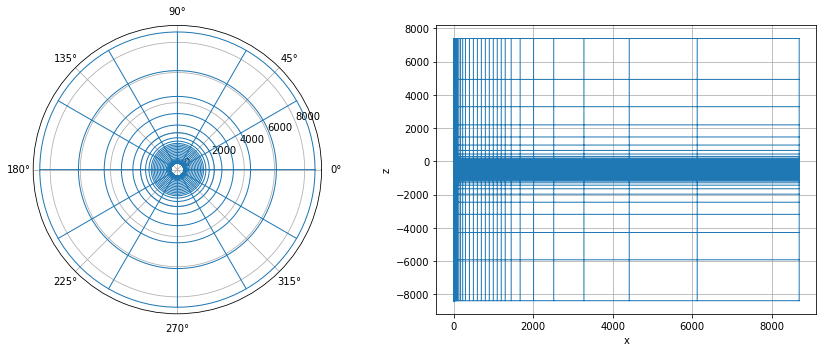

In [15]:
ax = meshGen.mesh.plotGrid()
# ax[0].set_rlim([50., 100.])
# ax[1].set_ylim([])

## Physical Properties

Now that we have a mesh and a model defined, we populate the mesh with physical properties

In [16]:
physprops_dict = {
    key: casingSim.model.PhysicalProperties(
        modelParameters=m, meshGenerator=meshGen
    )
    for key, m in model_dict.items() 
}


In [17]:
pp =physprops_dict["casing"]

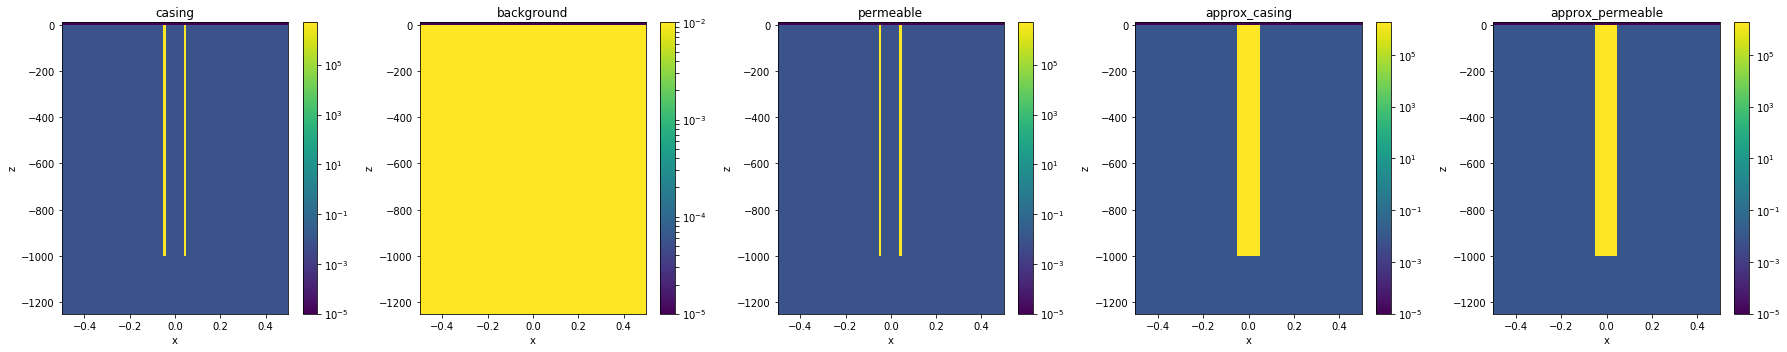

In [18]:
fig, ax = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))

xlim = 0.5*np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

for m, a in zip(model_names, ax):
    physprops_dict[m].plot_sigma(ax=a, pcolorOpts={'norm':LogNorm()})
    a.set_xlim(xlim)
    a.set_ylim(ylim) 
    a.set_title(m)

plt.tight_layout()

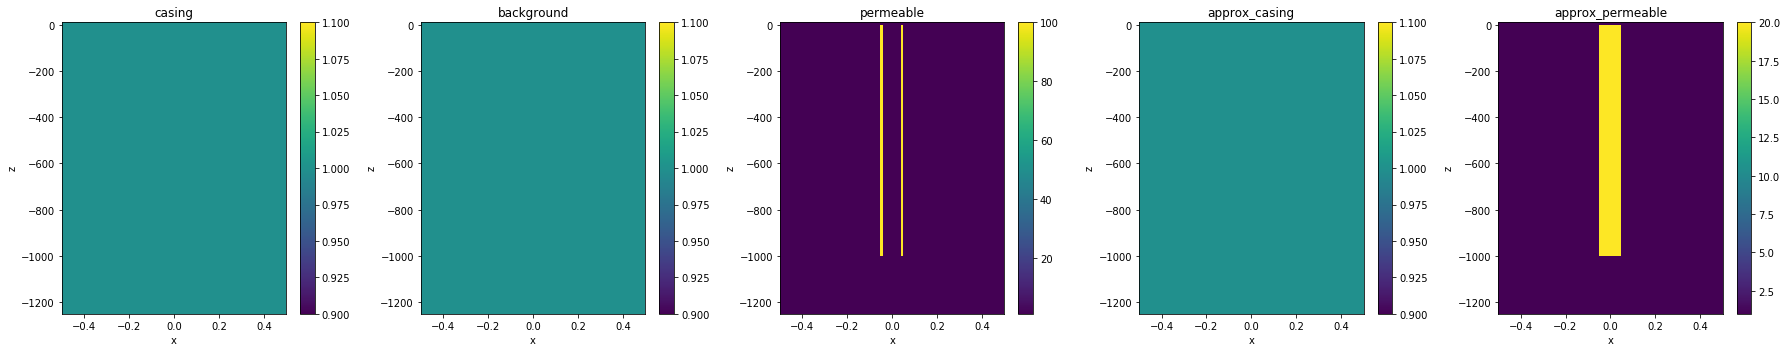

In [19]:
fig, ax = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))

xlim = 0.5*np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

for m, a in zip(model_names, ax):
    physprops_dict[m].plot_mur(ax=a)
    a.set_xlim(xlim)
    a.set_ylim(ylim) 
    a.set_title(m)

plt.tight_layout()

## Survey

The source is a grounded source with one electrode at 1000m and the other electrode connected to the top of the casing. A wire connects them. Note that we will use H-J formulation t solve this problem, so the source is defined as current that goes through the faces of the mesh. 

In [20]:
src_theta = np.pi/2. + mesh.hy[0]/2.
model.src_a[1] = src_theta
model.src_b[1] = src_theta

In [21]:
top_src_a = model.src_a.copy()
top_src_a[2] = -mesh.hz.min()/2.

In [22]:
downhole_src_a = model.src_a.copy()
downhole_src_a[0] = 0.
downhole_src_a[2] = -950.

In [23]:
src_top = casingSim.sources.TopCasingSrc(
    directory=simDir, 
    modelParameters=model, 
    meshGenerator=meshGen,
    src_a=top_src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="top_casing",
)

src_downhole = casingSim.sources.DownHoleCasingSrc(
    directory=simDir, 
    modelParameters=model,
    meshGenerator=meshGen,
    src_a=downhole_src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="downhole",
)

sources = [src_top, src_downhole]
srcList = src_top.srcList + src_downhole.srcList

In [24]:
casingSimSrcList = casingSim.sources.SourceList(
    filename="sources.json",
    directory=simDir,
    sources = sources   
)

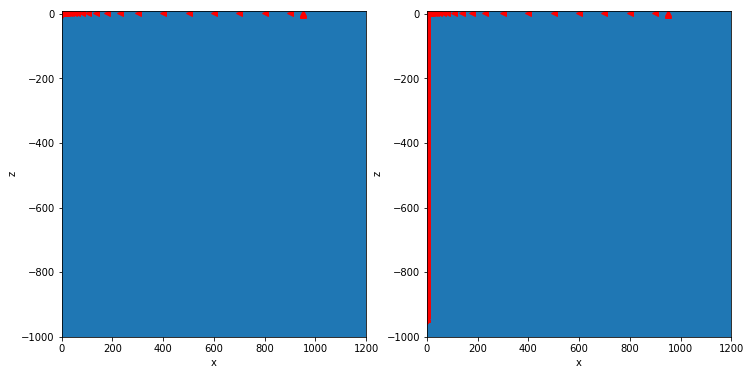

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for a, src in zip(ax, sources): 
    meshGen.mesh.plotGrid(slice='theta', ax=a)
    src.plot(ax=a)

    a.set_xlim([0., 1200])
    a.set_ylim([-1000., 10.])

## Simulation

In [26]:
model_dict

{'approx_casing': <casingSimulations.model.CasingInHalfspace at 0xd1fcc16a0>,
 'approx_permeable': <casingSimulations.model.CasingInHalfspace at 0xd1fcc1860>,
 'background': <casingSimulations.model.CasingInHalfspace at 0xd1fc9b898>,
 'casing': <casingSimulations.model.CasingInHalfspace at 0x1103e7b00>,
 'permeable': <casingSimulations.model.CasingInHalfspace at 0xd1fc9b8d0>}

In [27]:
sim = casingSim.run.SimulationTDEM(
    directory=simDir, 
    formulation='j',
    meshGenerator=meshGen,
    modelParameters=model,
    srcList=casingSimSrcList, 
)

sim.save()

Saved TDEM_fields_response_1km/simulationParameters.json


In [28]:
for key in model_names:
    model_dict[key].save()

Saved TDEM_fields_response_1km/casing.json
Saved TDEM_fields_response_1km/background.json
Saved TDEM_fields_response_1km/permeable.json
Saved TDEM_fields_response_1km/approx_casing.json
Saved TDEM_fields_response_1km/approx_permeable.json


In [29]:
casingSimSrcList.save()
meshGen.save()

Saved TDEM_fields_response_1km/sources.json
Saved TDEM_fields_response_1km/MeshParameters.json


In [30]:
m = "casing"
sim = casingSim.run.SimulationTDEM(
        modelParameters= simDir + "/" + m + ".json",
        meshGenerator=simDir + "/" +'MeshParameters.json',
        srcList=simDir + "/" +'sources.json',
        fields_filename=simDir + "/" +m + "_fields.npy"
    )

## load pre-computed results

In [31]:
# if use_downsampled_results:
#     f = "TDEM_fields_downsampled"
# else:
f = "TDEM_fields_response_1km"
    
# if not os.path.isdir(f):
#     download = Utils.download(
#         "https://storage.googleapis.com/simpeg/heagy_2018_emcyl/{}.tar.gz".format(f)
#     )  
#     tar = tarfile.open(download, "r:*")
#     tar.extractall()
#     tar.close()

load the results into memory

re-populate the fields object (this takes a couple minutes)

In [49]:
model_names

['casing', 'background', 'permeable', 'approx_casing', 'approx_permeable']

In [ ]:
%%time

# if rerun is False: 
    # recreate the fields object
fields_dict = {}

for key in [model_names[-1]]:
    
    if key not in fields_dict.keys():
        t = time.time()
        print("loading {}".format(key))
        sol = np.load(f + os.path.sep + "{}_fields.npy".format(key))
        sim.prob.model = physprops_dict[key].model
        fields_dict[key] = sim.prob.fieldsPair(sim.meshGenerator.mesh, sim.survey)
        print("   populating fields")
        fields_dict[key][:, 'jSolution', :] = sol
        print("... done. time: {:1.2f}s".format(time.time() - t))

loading approx_permeable


In [33]:
sim_dict = {key: sim for key in model_names}

In [34]:
viewer = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="casing"
)

In [35]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":0.15,
        "theta_ind":3, 
        "view":"j"
    }
)

interactive(children=(FloatText(value=0.15, description='max_r'), FloatText(value=-10.0, description='min_depth'), FloatText(value=1500.0, description='max_depth'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('casing', 'background', 'permeable', 'approx_casing', 'approx_permeable', 'all'), value='casing'), ToggleButtons(description='view', index=3, options=('sigma', 'mur', 'e', 'j', 'dbdt', 'dhdt', 'charge'), value='j'), ToggleButtons(description='prim_sec', options=('total', 'primary', 'secondary', 'percent'), value='total'), IntSlider(value=0, description='src_ind', max=1), IntSlider(value=3, description='theta_ind', max=11), IntSlider(value=0, description='time_ind', max=187), Checkbox(value=False, description='show_mesh'), Checkbox(value=False, description='use_aspect'), Checkbox(value=True, description='casing_outline'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [36]:
from matplotlib import rcParams
rcParams['font.size'] = 14

In [37]:
viewer.primary = "casing"

In [38]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":1.5*model.casing_l,
        "theta_ind":3,
        "view":"j"
    }, 
    figwidth=12
)

interactive(children=(FloatText(value=1500.0, description='max_r'), FloatText(value=-10.0, description='min_depth'), FloatText(value=1500.0, description='max_depth'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('casing', 'background', 'permeable', 'approx_casing', 'approx_permeable', 'all'), value='casing'), ToggleButtons(description='view', index=3, options=('sigma', 'mur', 'e', 'j', 'dbdt', 'dhdt', 'charge'), value='j'), ToggleButtons(description='prim_sec', options=('total', 'primary', 'secondary', 'percent'), value='total'), IntSlider(value=0, description='src_ind', max=1), IntSlider(value=3, description='theta_ind', max=11), IntSlider(value=0, description='time_ind', max=187), Checkbox(value=False, description='show_mesh'), Checkbox(value=False, description='use_aspect'), Checkbox(value=True, description='casing_outline'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

## Plan View 

In [39]:
viewer = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="background"
)

In [40]:
viewer.widget_depth_slice(
    fixed={"rotate": True, "figwidth":6, "k":10}, 
    defaults={"max_r":1500, "z_ind":400, "time_ind":1, "view":"j", "model_key":"casing", "use_aspect":True}
)

interactive(children=(FloatText(value=1500.0, description='max_r'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('casing', 'background', 'permeable', 'approx_casing', 'approx_permeable', 'all'), value='casing'), ToggleButtons(description='view', index=3, options=('sigma', 'mur', 'e', 'j', 'dbdt', 'dhdt', 'charge'), value='j'), ToggleButtons(description='prim_sec', options=('total', 'primary', 'secondary', 'percent'), value='total'), IntSlider(value=400, description='z_ind', max=443), IntSlider(value=0, description='src_ind', max=1), IntSlider(value=1, description='time_ind', max=187), Checkbox(value=True, description='use_aspect'), FloatText(value=0.0, description='theta_shift'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

plot data on the surface

In [41]:
# import dask

In [42]:
# @dask.delayed
def get_e_data(key, src_ind=0, xmin=5, xmax=1000, rx_times=np.logspace(-5, np.log10(1e-2), 20)):
    f = fields_dict[key]
    e = f[f.survey.srcList[src_ind], 'e', :]
    print('   fetched e')
    er = e[:mesh.vnF[0], :]
    
    e_tz_inds = (
        (mesh.gridFx[:, 0]>=xmin) & (mesh.gridFx[:, 0]<=xmax) & 
        (mesh.gridFx[:, 1] == mesh.vectorCCy[0]) & 
        (mesh.gridFx[:, 2] == -csz/2.)
    )

    x_inds = (mesh.vectorNx>=xmin) & (mesh.vectorNx<=xmax)
    rx_x = mesh.vectorNx[x_inds]
    
    time_inds = discretize.utils.closestPoints(f.survey.prob.timeMesh, rx_times, 'N')
    times = f.survey.prob.timeMesh.gridN[time_inds]
    
    e_data = (er[e_tz_inds, :])[:, time_inds]
    
    e_data = e_data.reshape(len(rx_x), len(times), order="F")
    
    return rx_x, times, e_data

In [43]:
e_data = {}

for key in model_names:
    print('getting {}'.format(key))
    e_data[key] = get_e_data(key)

getting casing
   fetched e
getting background
   fetched e
getting permeable
   fetched e
getting approx_casing
   fetched e
getting approx_permeable
   fetched e


In [44]:
# @dask.delayed
def get_dbdt_data(key, src_ind=0, xmin=5, xmax=1000, rx_times=np.logspace(-5, np.log10(1e-2), 20)):
    f = fields_dict[key]
    dbdt = f[f.survey.srcList[src_ind], 'dbdt', :]
    print('   fetched dbdt')
    dbdt = dbdt[mesh.vnE[0]:mesh.vnE[:2].sum(), :]
    
    dbdt_tz_inds = (
        (mesh.gridEy[:, 0]>=xmin) & (mesh.gridEy[:, 0]<=xmax) & 
        (mesh.gridEy[:, 1] == mesh.vectorCCy[0]) & 
        (mesh.gridEy[:, 2] == 0)
    )

    x_inds = (mesh.vectorNx>=xmin) & (mesh.vectorNx<=xmax)
    rx_x = mesh.vectorNx[x_inds]
    
    time_inds = discretize.utils.closestPoints(f.survey.prob.timeMesh, rx_times, 'N')
    times = f.survey.prob.timeMesh.gridN[time_inds]
    
    dbdt_data = (dbdt[dbdt_tz_inds, :])[:, time_inds]
    
    dbdt_data = dbdt_data.reshape(len(rx_x), len(times), order="F")
    
    return rx_x, times, dbdt_data

In [45]:
dbdt_data = {}

for key in model_names:
    print('getting {}'.format(key))
    dbdt_data[key] = get_dbdt_data(key)

getting casing
   fetched dbdt
getting background
   fetched dbdt
getting permeable
   fetched dbdt
getting approx_casing
   fetched dbdt
getting approx_permeable
   fetched dbdt


In [46]:
from matplotlib import colors
from matplotlib import cm as cmap

In [47]:
cm = plt.get_cmap('magma')
c_norm = colors.LogNorm(vmin=(e_data["background"][1]).min(), vmax=e_data["background"][1].max()*3)
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

In [ ]:
# fig, ax = plt.subplots(1, 1)
# for key, ls in zip(model_names[1:], ['-', 'o', 'd']):
#     x, t, e = e_data[key]
    
#     for i, time in enumerate(t):
#         color=scalar_map.to_rgba(time)
#         ax.semilogy(x, np.absolute(e[:, i]), ls, color=color, markersize="2")
# # plt.semilogy(-e_data, '--')

In [ ]:
# fig, ax = plt.subplots(1, 1)
# x, t, e = e_data[key]

# for i, time in enumerate(t):
#     color=scalar_map.to_rgba(time)
#     ax.semilogy(x, (e_data["permeable"][2][:, i] - e_data["casing"][2][:, i]), '-', color=color, markersize="2")
#     ax.semilogy(x, -(e_data["permeable"][2][:, i] - e_data["casing"][2][:, i]), '--', color=color, markersize="2")

#     # plt.semilogy(-e_data, '--')

In [50]:
from string import ascii_lowercase
from matplotlib import rcParams

rcParams['font.size'] = 14

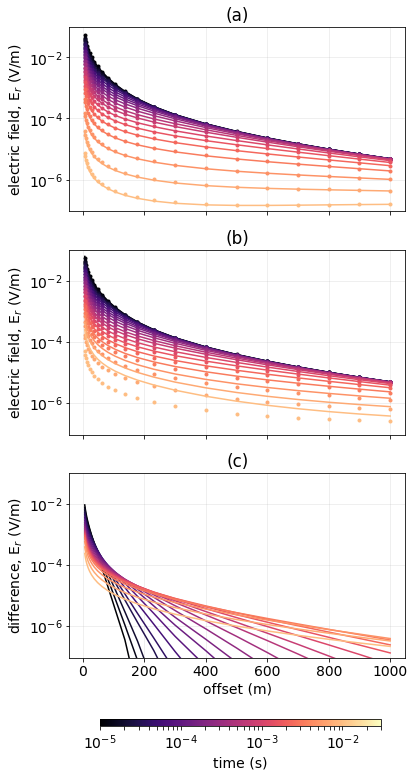

In [51]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))
# for key, ls in zip(model_names[1:], ['-', 'o', 'd']):
x, t, e = e_data[key]

def plot_semilogy(x, data, color, ax, plot_sign=False, ls='-'):
    
    if plot_sign is True:
        pos = data >= 0   
        ax.semilogy(x[pos], data[pos], '-', color=color)
        ax.semilogy(x[~pos], -data[~pos], '--', color=color)
    else:
        ax.semilogy(x, np.absolute(data), ls, color=color)

for i, time in enumerate(t):
    color=scalar_map.to_rgba(time)
    
    plot_semilogy(x, e_data["casing"][2][:, i], color, ax[0]) # casing
    plot_semilogy(x, e_data["approx_casing"][2][:, i], color, ax[0], ls='.') # casing
    
    plot_semilogy(x, e_data["permeable"][2][:, i], color, ax[1]) # permeable
    plot_semilogy(x, e_data["approx_permeable"][2][:, i], color, ax[1], ls='.') # permeable
    
    plot_semilogy(x, e_data["permeable"][2][:, i] - e_data["casing"][2][:, i], color, ax[2]) # difference

for i, a in enumerate(ax):
    a.set_ylim([9e-8, 1e-1])
    a.grid(which="both", alpha=0.4, lw=0.5)
    a.set_title('({})'.format(ascii_lowercase[i]))
    
    if i < len(ax)-1:
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        a.set_ylabel('electric field, E$_r$ (V/m)')
    else:
        a.set_xlabel('offset (m)')
        a.set_ylabel('difference, E$_r$ (V/m)')


plt.tight_layout()
cbar_ax = fig.add_axes([0.25, -0.02, 0.65, 0.01])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (s)')

# fig.savefig("../figures/tdem_surface_e_fields", bbox_inches="tight", dpi=200)



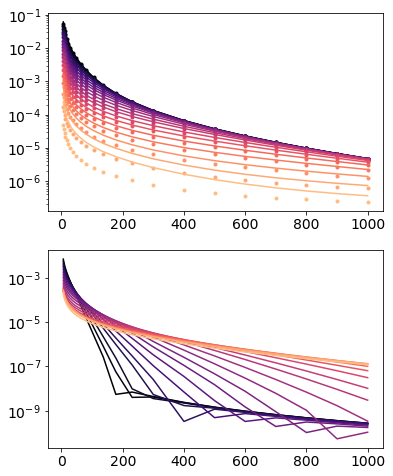

In [55]:
fig, ax = plt.subplots(2,1, figsize=(6, 8))

for i, time in enumerate(t):
    color=scalar_map.to_rgba(time)
    
    plot_semilogy(x, e_data["permeable"][2][:, i], color, ax[0]) # permeable
    plot_semilogy(x, e_data["approx_permeable"][2][:, i], color, ax[0], ls='.') # permeable

    plot_semilogy(x, e_data["approx_permeable"][2][:, i]-e_data["permeable"][2][:, i], color, ax[1]) # permeable
#     plot_semilogy(x, , color, ax[1], ls='.') # permeable

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))
# for key, ls in zip(model_names[1:], ['-', 'o', 'd']):
x, t, dbdt = dbdt_data[key]

def plot_semilogy(x, data, color, ax, plot_sign=False):
    
    if plot_sign is True:
        pos = data >= 0   
        ax.semilogy(x[pos], data[pos], '-', color=color)
        ax.semilogy(x[~pos], -data[~pos], '--', color=color)
    else:
        ax.semilogy(x, np.absolute(data), '-', color=color)

for i, time in enumerate(t):
    color=scalar_map.to_rgba(time)
    
    plot_semilogy(x, dbdt_data["casing"][2][:, i], color, ax[0]) # casing
    plot_semilogy(x, dbdt_data["approx_casing"][2][:, i], color, ax[0], '.') # casing
    
    plot_semilogy(x, dbdt_data["permeable"][2][:, i], color, ax[1]) # permeable
    plot_semilogy(x, dbdt_data["approx_permeable"][2][:, i], color, ax[1], '.') # permeable
    
    plot_semilogy(x, dbdt_data["permeable"][2][:, i] - dbdt_data["casing"][2][:, i], color, ax[2]) # difference

for i, a in enumerate(ax):
    a.set_ylim([1, 1e8])
    a.grid(which="both", alpha=0.4, lw=0.5)
    a.set_title('({})'.format(ascii_lowercase[i]))
    
    if i < len(ax)-1:
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        a.set_ylabel('db$_{\\theta}$/dt, (V)')
    else:
        a.set_xlabel('offset (m)')
        a.set_ylabel('db$_{\\theta}$/dt, (V)')


plt.tight_layout()
cbar_ax = fig.add_axes([0.25, -0.02, 0.65, 0.01])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (s)')

# fig.savefig("../figures/tdem_surface_dbdt", bbox_inches="tight", dpi=200)



In [ ]:
t.shape

## Figure 7

Lots of plotting code so that the look nice!

In [ ]:
fields_dict2 = {}
sim_dict2 = {}

for key, sim in sim_dict.items():
    sim_dict2[key] = sim.copy()
    sim_dict2[key]._prob = sim._prob
    sim_dict2[key]._survey = sim._survey

if use_downsampled_results:
    f = "TDEM_fields_publication"
    if not os.path.isdir(f):
        download = Utils.download(
            "https://storage.googleapis.com/simpeg/heagy_2018_emcyl/{}.tar.gz".format(f)
        )  
        tar = tarfile.open(download, "r:*")
        tar.extractall()
        tar.close()
        
    jSolution = np.load(f + os.path.sep + 'fields.npy')
    jSolution_background = np.load(f + os.path.sep + 'fields_background.npy')
    
    times = np.load(f + os.path.sep + 'times.npy')    
    timesteps = np.hstack(np.diff(times))
    
    plt_times = np.arange(0, len(times))
    
    for sim in sim_dict2.values():
        sim.prob.timeSteps = timesteps

    # recreate the fields object
    for key, sim in sim_dict2.items():
        sim.prob.model = physprops_dict[key].model
        fields_dict2[key] = sim.prob.fieldsPair(sim.meshGenerator.mesh, sim.survey)    
        
    fields_dict2["casing"][:,'jSolution',:] = jSolution
    fields_dict2["background"][:,'jSolution',:] = jSolution_background
        
else:
    plt_times = [0, 10, 28, 73, 118, 136]
    fields_dict2 = fields_dict

In [ ]:
from matplotlib import rcParams
from matplotlib import gridspec
rcParams['font.size'] = 24

In [ ]:
viewer2 = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict2, fields_dict=fields_dict2, primary_key="background"
)

In [ ]:
# mod = ['3D']
clim_max = 2e-4 
clim_min = 8e-9
clim = np.r_[clim_min, clim_max]

clim_max_casing = 3e2
clim_min_casing = 8e-9
clim_casing = np.r_[clim_min_casing, clim_max_casing]

max_depth = 1.4*casing_l
max_r_casing = 0.149
top=10.,

xlim = 1500.*np.r_[-1., 1.]

zinds = [400, 101]

x_ticks = [0, -500, -1000, -1500]

# fig, ax = plt.subplots(4, len(plt_times), figsize )

fig = plt.figure(figsize=(28, 5.5*len(plt_times)), dpi=50) 
fig.subplots_adjust(bottom=0.8)

gs = gridspec.GridSpec(len(plt_times), 4, width_ratios=[1, 4, 2, 2]) 
ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*4)]

for i, tind in enumerate(plt_times):
    
    ax0 = ax[i*4 + 1]
    ax1 = ax[i*4 + 2]
    ax2 = ax[i*4 + 3]
    ax3 = ax[i*4]
    
    # currents in the formation
    out = viewer2.plot_cross_section(
        ax=ax0, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
        model_key='casing', show_cb=False, use_aspect=True,
        casing_outline=True
    )
        
    
    # plot depth slice above
    for a, z_ind in zip([ax1, ax2], zinds):
        out = viewer2.plot_depth_slice(
            xlim=xlim, ylim=xlim, clim=clim,
            ax=a, z_ind=z_ind, model_key='casing', view='j',
            show_cb=False, time_ind=tind, rotate=True
        )
    
    ax2.text(-300, 1250, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=22)

    
    # zoomed in plot
    # currents in the formation
    out_casing = viewer2.plot_cross_section(
        ax=ax3, clim=clim_casing, zlim=np.r_[-max_depth, top],
        xlim=max_r_casing*np.r_[-1., 1.],
        view='j', theta_ind=3, time_ind=tind, 
        model_key='casing', show_cb=False, casing_outline=True
    )
    ax3.set_ylim(np.r_[-max_depth, top])
    ax3.set_ylabel('z (m)')
#     ax3.set_yticks(z_ticks)
    
    for a in [ax0, ax1, ax2, ax3]:
        a.set_title('')
        if a != ax3: 
            a.set_aspect(1)
            
        if tind == plt_times[-1]:
            a.set_xlabel('x (m)')
        else: 
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
        
        if a in [ax2, ax0]:
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))
    
        if a == ax1:
            a.set_ylabel('y (m)')
        
            
    if tind == 0:
        ax0.set_title('(b) Cross section\ny = 0m\n')
        ax1.set_title('(c) Depth slice\nz = {:1.0f}m\n'.format(sim.prob.mesh.vectorCCz[zinds[0]]))
        ax2.set_title('(d) Depth slice\nz = {:1.0f}m\n'.format(sim.prob.mesh.vectorCCz[zinds[1]])) 
        ax3.set_title('(a) Cross section\ny = 0m\n')
        
plt.tight_layout()

cbar_ax = fig.add_axes([0.25, -0.01, 0.65, 0.01])
cb = plt.colorbar(out[0], cbar_ax, orientation='horizontal')
cb.set_label('Current density (A/m$^2$)')

cbar_ax2 = fig.add_axes([0.06, -0.01, 0.11, 0.01])
cb2 = plt.colorbar(out_casing[0], cbar_ax2, orientation='horizontal')
cb2.set_label('Current density (A/m$^2$)')
cb2.set_ticks([1e-8, 1e2])
cb2.update_ticks()

plt.show()

In [ ]:
fig.savefig('../figures/tdem_currents', bbox_inches='tight', dpi=300)
fig.savefig('../arxiv-figures/tdem_currents', bbox_inches='tight', dpi=150)